# End-to-end Solar Out-of-Distribution (SOoD) pipeline

This notebook presents an end-to-end training and prediction pipeline for Anomaly Detection with a context-encoding variational autoencoder.

The model is based on the following paper: Zimmerer, David, et al. "Context-encoding variational autoencoder for unsupervised anomaly detection." arXiv preprint arXiv:1812.05941 (2018).

##__Download Code & Data</center>__


In [1]:
!git clone -b main 'https://github.com/i4DS/sdo-cli.git'

Cloning into 'sdo-cli'...
remote: Enumerating objects: 403, done.
remote: Counting objects: 100% (403/403), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 403 (delta 207), reused 394 (delta 207), pack-reused 0
Receiving objects: 100% (403/403), 46.84 MiB | 24.35 MiB/s, done.
Resolving deltas: 100% (207/207), done.


In [2]:
cd sdo-cli

/content/sdo-cli


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.8 MB 12.7 MB/s 
     |████████████████████████████████| 144 kB 45.9 MB/s 
     |████████████████████████████████| 181 kB 54.3 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 


In [5]:
# Log in to your W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
!mkdir -p "/content/sdo-cli/data"

In [7]:
!tar -xf "../drive/MyDrive/Master/Data/AIA_0171_201201.tar" -C "/content/sdo-cli/data"

In [8]:
!ls -la /content/sdo-cli/data

total 12
drwxr-xr-x  3 root  root  4096 Apr 16 12:30 .
drwxr-xr-x  8 root  root  4096 Apr 16 12:30 ..
drwxrwxr-x 33 21217 staff 4096 Dec 19  2018 01


In [9]:
%env PYTHONPATH="$/env/python:/content/sdo-cli/src"

!echo $PYTHONPATH

env: PYTHONPATH="$/env/python:/content/sdo-cli/src"
"$/env/python:/content/sdo-cli/src"


In [ ]:
!pip install -r requirements.txt

In [11]:
!pip install -U sunpy python-dotenv

     |████████████████████████████████| 6.0 MB 9.4 MB/s 
     |████████████████████████████████| 1.1 MB 29.7 MB/s 
     |████████████████████████████████| 144 kB 48.0 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
     |████████████████████████████████| 271 kB 39.8 MB/s 


In [12]:
%cd /content/sdo-cli/src
!pip install --editable .

/content/sdo-cli/src
Obtaining file:///content/sdo-cli/src
  Running setup.py develop for sdo-cli


## Data Acquisition

Make sure to run the setup and install `sdo-cli` first (`make setup` and `make install`).

In [14]:
# download the dataset
# Refer to https://github.com/i4Ds/awesome-helio/tree/main/datasets/machine-learning-dataset-for-sdo

In [7]:
#load the data

from pathlib import Path
import numpy as np
import os 
import sunpy
from sunpy.visualization.colormaps import cm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torchvision
import torch
import torchvision.transforms.functional as F
from sdo.sood.data.sdo_ml_v1_dataset import get_sdo_ml_v1_dataset

%config InlineBackend.figure_format = 'retina'

data_dir = "/Users/mariusgiger/repos/master/test-sdo-ml-dataset-ae/extract"
train_loader = get_sdo_ml_v1_dataset(
                base_dir=data_dir,
                num_workers=0,
                pin_memory=False,
                batch_size=16,
                mode="train",
                target_size=512,
            )

found 7240 files


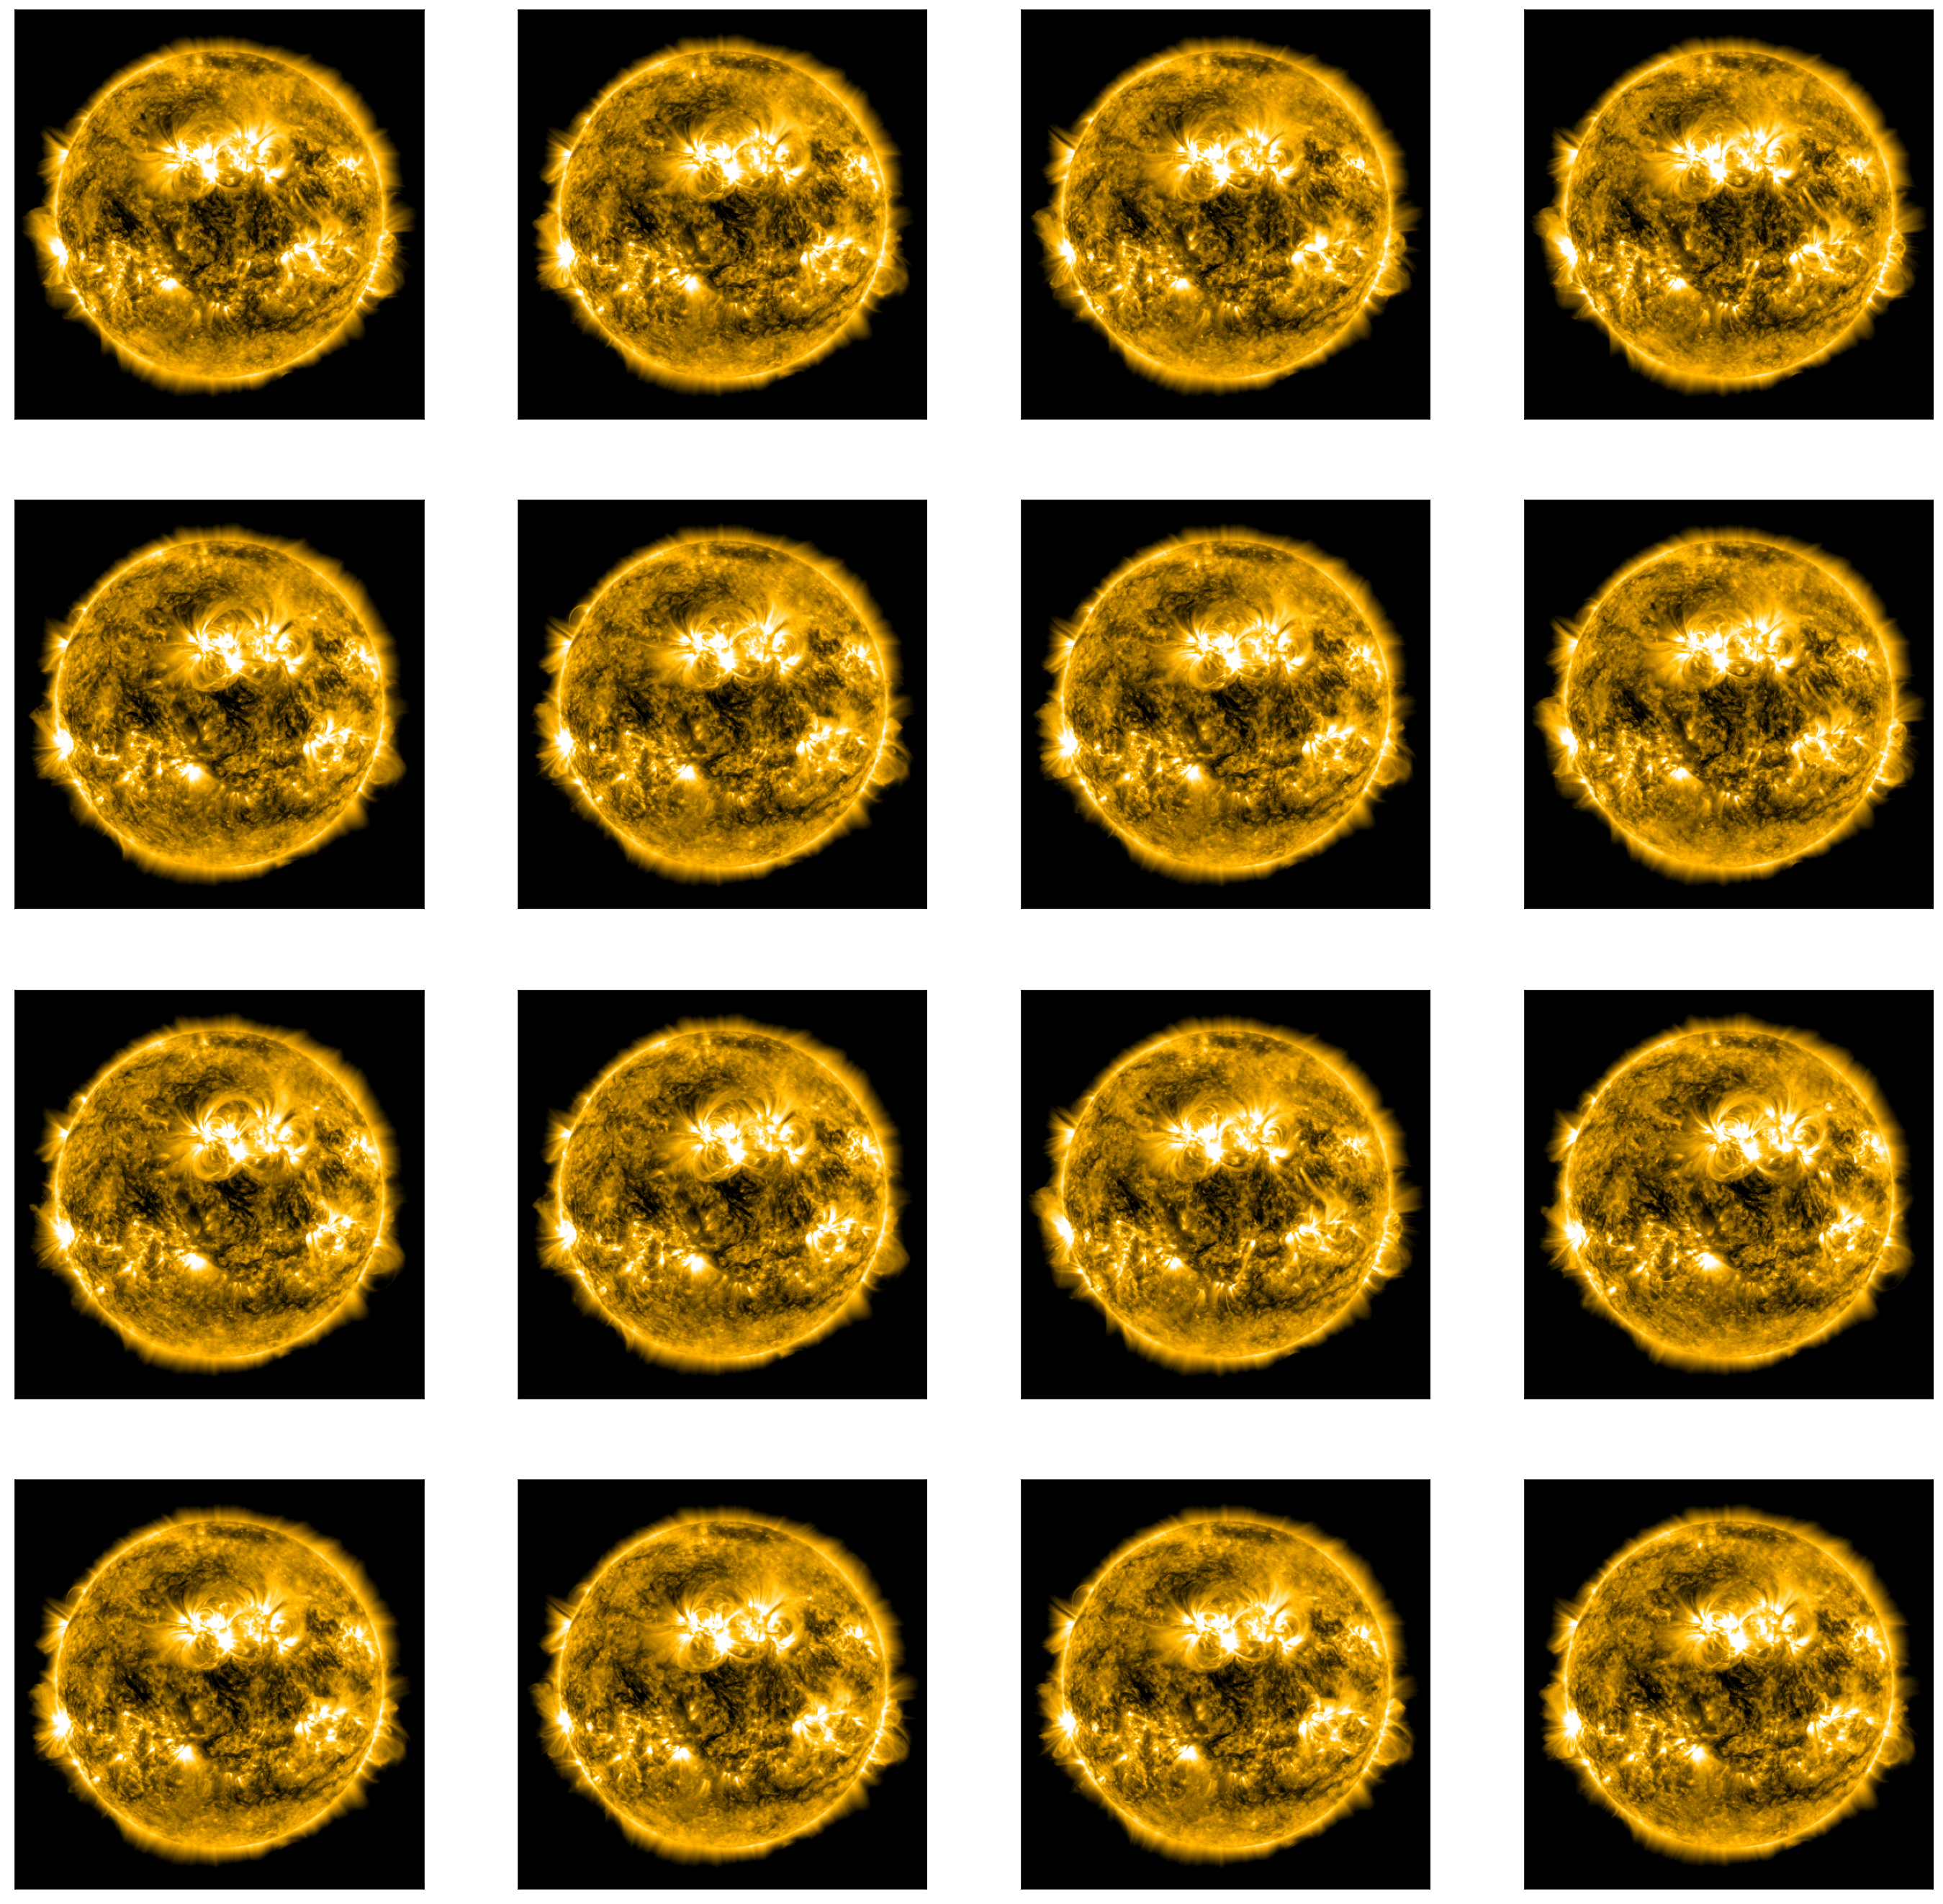

In [8]:
#inspect an image

#Channels that correspond to HMI Magnetograms 
HMI_WL = ['bx','by','bz']
#A colormap for visualizing HMI
HMI_CM = LinearSegmentedColormap.from_list("bwrblack", ["#0000ff","#000000","#ff0000"])

def channel_to_map(name):
    """Given channel name, return colormap"""
    return HMI_CM if name in HMI_WL else cm.cmlist.get('sdoaia%d' % int(name))

def get_clip(X,name):
    """Given an image and the channel name, get the right clip"""
    return get_signed_pct_clip(X) if name in HMI_WL else get_pct_clip(X)

def get_pct_clip(X):
    """Return the 99.99th percentile"""
    return (0,np.quantile(X.ravel(),0.999))

def get_signed_pct_clip(X):
    """Return the 99.99th percentile by magnitude, but symmetrize it so 0 is in the middle"""
    v = np.quantile(np.abs(X.ravel()),0.999)
    return (-v,v)

def vis(X, cm, clip):
    """Given image, colormap, and a clipping, visualize results"""
    Xc = np.clip((X-clip[0])/(clip[1]-clip[0]),0,1)
    Xcv = cm(Xc)
    return (Xcv[:,:,:3]*255).astype(np.uint8)

def show_grid(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(figsize=(24,24), ncols=4, nrows=int(len(imgs)/4), squeeze=False)
    row = 0
    for i, img in enumerate(imgs):
        col = i % 4
        if i != 0 and i % 4 == 0:
            row = row + 1
        axs[row, col].imshow(img)
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

# https://pytorch.org/vision/stable/generated/torchvision.utils.make_grid.html     
for batch_idx, samples in enumerate(train_loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map(171), get_clip(x, 171))
        V.append(Image.fromarray(v))
    show_grid(V)
    break
    

## Training

For a visual inspection of the training process start a [Visdom Server](https://github.com/fossasia/visdom): `make visdom`. Head over to [http://localhost:8080](http://localhost:8080) and start the training:

In [9]:
# training a ceVAE model for the downloaded images (note that a much larger dataset should be used in practice)

output_dir = "./output/train-sdo-ml"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

!sdo-cli sood ce_vae train \
    --target-size=256 \
    --data-dir=$data_dir \
    -o "./output/train-sdo-ml"\
    --ce-factor 0.5 \
    --print-every-iter 1 \
    --score-mode "combi" \
    --n-epochs 10 \
    --batch-size 4 \
    --dataset "SDOMLDatasetV1"

2022-04-22 11:06:06,662 torch.distributed.nn.jit.instantiator INFO Created a temporary directory at /var/folders/ky/6sknwmm56yv_95j_xml935h40000gn/T/tmp2ppe3o9k
2022-04-22 11:06:06,662 torch.distributed.nn.jit.instantiator INFO Writing /var/folders/ky/6sknwmm56yv_95j_xml935h40000gn/T/tmp2ppe3o9k/_remote_module_non_sriptable.py
found 7240 files
found 0 files
wandb: Currently logged in as: mariusgiger (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.12.14
wandb: Run data is saved locally in /Users/mariusgiger/repos/master/sdo-cli/notebooks/wandb/run-20220422_110608-1lf0wfcr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run colorful-lake-55
wandb: ⭐️ View project at https://wandb.ai/mariusgiger/sdo-sood
wandb: 🚀 View run at https://wandb.ai/mariusgiger/sdo-sood/runs/1lf0wfcr
2022-04-22 11:06:10,286 pytorch_lightning.utilities.ran

## Predict

In [ ]:
import os, glob

def find_newest_dir(pattern):
    newest_dir = max(glob.glob(pattern), key=os.path.getmtime)
    print(newest_dir)
    return newest_dir

In [ ]:
# pixel-level predictions

import os 

train_path = find_newest_dir('./output/train/*/')
load_path = train_path / Path('checkpoint')

pred_output_dir = "./output/pred"
if not os.path.exists(pred_output_dir):
    os.makedirs(pred_output_dir)
    
!sdo-cli sood ce_vae predict \
    --target-size=256 \
    --data-dir='./data/aia_171_2012_256' \
    --test-dir='./data/aia_171_2012_full_disk_flare_256' \
    --load-path={load_path} \
    -o './output/pred' \
    --logger "file" \
    --ce-factor 0.5 \
    --score-mode combi \
    --mode="pixel"

In [1]:
from sdo.sood.algorithms.ce_vae import ceVAE

load_path = "/Users/mariusgiger/Downloads/model_cevae_256.ckpt"
mode = "sample"
cevae_algo = ceVAE.load_from_checkpoint(
            load_path, mode=mode)
cevae_algo.eval()

ceVAE(
  (model): VAE(
    (enc): BasicEncoder(
      (start): ConvModule(
        (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (middle_blocks): ModuleList(
        (0): NoOp()
        (1): ConvModule(
          (conv): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): NoOp()
        (3): ConvModule(
          (conv): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (4): NoOp()
        (5): ConvModule(
          (conv): Conv2d(256, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (activation): LeakyReLU(negative_slope=0.01)
        )
      )
      (end): ConvModule(
        (conv): Conv2d(1024, 512, kernel_size=(16, 16), stride=(1, 1), bias=False

In [4]:
import pathlib 
import numpy as np
import torch
from torchvision.transforms import Compose, Resize, Normalize, Lambda
import math
from torchvision.utils import save_image

CHANNEL_PREPROCESS = {
    "94": {"min": 0.1, "max": 800, "scaling": "log10"},
    "131": {"min": 0.7, "max": 1900, "scaling": "log10"},
    "171": {"min": 5, "max": 3500, "scaling": "log10"},
    "193": {"min": 20, "max": 5500, "scaling": "log10"},
    "211": {"min": 7, "max": 3500, "scaling": "log10"},
    "304": {"min": 0.1, "max": 3500, "scaling": "log10"},
    "335": {"min": 0.4, "max": 1000, "scaling": "log10"},
    "1600": {"min": 10, "max": 800, "scaling": "log10"},
    "1700": {"min": 220, "max": 5000, "scaling": "log10"},
    "4500": {"min": 4000, "max": 20000, "scaling": "log10"},
    "continuum": {"min": 0, "max": 65535, "scaling": None},
    "magnetogram": {"min": -250, "max": 250, "scaling": None},
    "bx": {"min": -250, "max": 250, "scaling": None},
    "by": {"min": -250, "max": 250, "scaling": None},
    "bz": {"min": -250, "max": 250, "scaling": None},
}

predict_img_path = pathlib.Path("/Users/mariusgiger/repos/master/test-sdo-ml-dataset-ae/extract/train/2012/01/01/AIA20120101_0000_0171.npz")

np_arr = np.load(predict_img_path)["x"]  # .astype(np.float64)
torch_arr = torch.from_numpy(np_arr)
# convert to 1 x H x W, to be in compatible torchvision format
torch_arr = torch_arr.unsqueeze(dim=0)

channel = "171"
preprocess_config = CHANNEL_PREPROCESS[channel.lower()]

target_size = 256
if preprocess_config["scaling"] == "log10":
    # TODO why was vflip(x) used here in SolarNet?
    def lambda_transform(x): return torch.log10(torch.clamp(
            x,
            min=preprocess_config["min"],
            max=preprocess_config["max"],
    ))
    mean = math.log10(preprocess_config["min"])
    std = math.log10(preprocess_config["max"]) - \
            math.log10(preprocess_config["min"])
else:
    def lambda_transform(x): return torch.clamp(
            x,
            min=preprocess_config["min"],
            max=preprocess_config["max"],
    )
    mean = preprocess_config["min"]
    std = preprocess_config["max"] - preprocess_config["min"]

transforms = Compose(
        [Resize((target_size, target_size)),
         Lambda(lambda_transform),
         Normalize(mean=[mean], std=[std]),
         # required to remove strange distribution of pixels (everything too bright)
         Normalize(mean=(0.5), std=(0.5))
         ]
)
torch_arr = transforms(torch_arr)
with torch.no_grad():
    cevae_algo.sample_mode()
    pred = cevae_algo.forward(torch_arr)
    print(pred)
cevae_algo.pixel_mode()
#NOTE this mode requires grad to be enabled
pred_img = cevae_algo.forward(torch_arr)
save_image(pred_img, "./output/test.png", normalize=True)    

0.07127389311790466


In [ ]:
# display inverted pixel-wise anomaly scores

from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 

aia_wave = 171
newest_dir = find_newest_dir('./output/pred/*/')
pixel_pred_path =  newest_dir / Path("predictions")
images = list(Path(pixel_pred_path).rglob(f'*__{aia_wave}.jpeg'))

f, axarr = plt.subplots(1,7, figsize=(20, 9))

row_index = 0
column_index = 0

for index, path in enumerate(images):
    img = Image.open(path)
    img_arr = np.invert(np.asarray(img))
    axarr[column_index].set_title(path.stem)
    axarr[column_index].imshow(img_arr, cmap='gray', vmin=0, vmax=255)
    axarr[column_index].spines['top'].set_visible(False)
    axarr[column_index].spines['right'].set_visible(False)
    axarr[column_index].spines['bottom'].set_visible(False)
    axarr[column_index].spines['left'].set_visible(False)
    axarr[column_index].xaxis.set_ticks([])
    axarr[column_index].yaxis.set_ticks([])

    if(column_index == 6):
        row_index = (row_index + 1)
        
    column_index = (column_index + 1) % 7

In [ ]:
# sample-level predictions

!sdo-cli sood ce_vae predict \
    --target-size=256 \
    --data-dir='./data/aia_171_2012_256' \
    --test-dir='./data/aia_171_2012_full_disk_flare_256' \
    --load-path={load_path} \
    -o './output/pred' \
    --logger "file" \
    --ce-factor 0.5 \
    --score-mode combi \
    --mode="sample"

In [ ]:
# investigate sample-wise scores

import pandas as pd

newest_dir = find_newest_dir('./output/pred/*/')
sample_pred_path =  newest_dir / Path("predictions/predictions.txt")

df = pd.read_csv(sample_pred_path, header=None, names = ["img", "score"])
df.head(7)

In [ ]:
df.describe()

In [ ]:
!sdo-cli sood ce_vae generate \
    --target-size=256 \
    --data-dir='./data/aia_171_2012_256' \
    --test-dir='./data/aia_171_2012_full_disk_flare_256' \
    --load-path={load_path} \
    -o './output/' \
    --logger "file" \
    --ce-factor 0.5 \
    --score-mode combi \
    --mode="sample"

In [ ]:
gen_data_dir = "./output"
images = list(Path(gen_data_dir).rglob(f'*_generated.jpeg'))
img_path = images[0]

fig = plt.figure(figsize=(15, 15))
plt.axis('off')

src_img = Image.open(img_path)
plt.imshow(np.asarray(src_img))